# GPN-MSA: variant effect prediction

In [1]:
#!pip install --quiet git+https://github.com/songlab-cal/gpn.git

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Local download is a lot faster, for how to improve performance see README:
# https://huggingface.co/datasets/songlab/multiz100way

# Streaming (inference takes 5-10 minutes, might depend on network connection)
msa_path = "zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip"

# Using a local file (inference takes 5 seconds)
#msa_path = "../../analysis/human/results/msa/multiz100way/89/all.zarr"

In [9]:
model_path = "songlab/gpn-msa-sapiens"

# Input file requirements:
# Either a HuggingFace dataset or a file
# Should automatically detect .parquet, .vcf, .vcf.gz, .csv, .csv.gz, .tsv, .tsv.gz
# Will only use chrom, pos, ref, alt (hg38 coordinates)
# chrom should be in 1,...,22,X,Y (string)
# ref, alt should be in A,C,G,T
# ref must match the reference genome

# Small VCF with 1000 positive and 1000 negative variants from our ClinVar benchmark
# can download from https://raw.githubusercontent.com/songlab-cal/gpn/main/examples/msa/example.vcf
input_path = "example.vcf"
# For now the output is just a single column "score", in the same order as input_path
output_path = "example.preds.parquet"

# The script will detect any number of available GPUs (can also run without GPU)
per_device_batch_size = 128 # whatever fits in your GPU
# how many CPUs you want to use
# anything > 0 get's frozen when using the remote (streaming) msa_path
# for local download can set equal to number of CPUs
dataloader_num_workers = 0 
window_size = 128
python_path = "/scratch/users/gbenegas/software/mambaforge/envs/gpn/bin/python"  # might just be "python" in your system

In [10]:
!{python_path} -m gpn.msa.inference vep {input_path} {msa_path} {window_size} {model_path} {output_path} \
    --is_file \
    --per_device_batch_size {per_device_batch_size} --dataloader_num_workers {dataloader_num_workers}

Namespace(command='vep', input_path='example.vcf', msa_path='zip:///::https://huggingface.co/datasets/songlab/multiz100way/resolve/main/89.zarr.zip', window_size=128, model_path='songlab/gpn-msa-sapiens', output_path='example.preds.parquet', per_device_batch_size=128, dataloader_num_workers=0, split='test', is_file=True, disable_aux_features=False, center_window_size=None)
Loading MSA...
Loading MSA... Done
100%|███████████████████████████████████████████| 16/16 [05:41<00:00, 21.37s/it]


In [17]:
V = pd.read_csv(input_path, sep="\t", comment="#", header=None).rename(columns={
    0: "chrom", 1: "pos", 2: "id", 3: "ref", 4: "alt"
})
V["label"] = V.id.str.split("_").str[0]
V["score"] = pd.read_parquet(output_path).score.values.ravel()
V

,chrom,pos,id,ref,alt,label,score
0,1,1180851,Common_1501,T,C,Common,1.851778
1,1,1233177,Pathogenic_1790,G,C,Pathogenic,-7.247392
2,1,1312290,Pathogenic_2057,C,T,Pathogenic,-5.155979
3,1,1927692,Common_4064,C,T,Common,0.583127
4,1,1930143,Common_4073,C,T,Common,-6.271775
...,...,...,...,...,...,...,...
1995,X,154966523,Pathogenic_9761197,A,G,Pathogenic,-7.370640
1996,X,154966664,Pathogenic_9761201,C,A,Pathogenic,-8.240108
1997,X,154993046,Pathogenic_9761224,C,A,Pathogenic,-7.077174
1998,Y,2787515,Pathogenic_9761263,C,A,Pathogenic,-0.703199


<Axes: xlabel='score', ylabel='Count'>

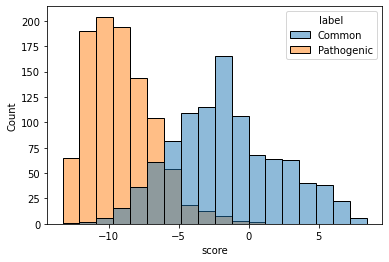

In [18]:
sns.histplot(data=V, x="score", hue="label")